In [21]:
%cd Documents/LSC/LSC_Sentiment_Analysis/

[WinError 3] Das System kann den angegebenen Pfad nicht finden: 'Documents/LSC/LSC_Sentiment_Analysis/'
c:\Users\Dell\OneDrive\Desktop\Uni\Semester 2\Ökonometrie\GitHub\LSC_Sentiment_Analysis


# Sentiment Analysis mit Bag-of-Words und TFIDF

Im folgenden nehmen wir die Sentiment Analyse mit dem Bag-of-Words (BoW), sowie term-frequency-inverse-document-frequency (TFIDF) vor.   
Beim Bow ..  
Im Gegenzug dazu berücksichtigen wir bei der Bestimmung von TFIDF Features nicht nur die term-frequency sondern zusätzlich die inverse document frequency.  

  
Sowohl BoW als auch TFIDF haben wir mit verschiedenen N-Grams angewandt um die Ergebnisse miteinander zu vergleichen. 
Wir haben Unigrams, Bigrams sowie Trigrams verwendet. 

Anschließend haben wir die Daten mit Naiv Bayes, Logistischer Regression sowie LSVM geschätzt.

Dieses Vorgehen haben wir auf zwei unterschiedlichen Datensätzen angewandt:   
- Movie Revies: kleineres Data-Set, was  3 Klassen enthält (-1: negativ, 0: neutral, 1: positiv)  
- Twetts: größeres Datenset, was 2 Klassen enthält (-1: negativ, 1: positiv)  

Die Accuracys haben wir abschließend miteinander verglichen 

## Movie Reviews (smaller Data-Set)

In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import sklearn
import nltk
import re
import csv
from evaluation import test_statistics
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import matplotlib.pyplot as plt  



In [23]:
#%cd ..

## 1. Data Loading

In [15]:
train_set = pd.read_csv ("./data/dataset_mr/Trainset_complete.csv", sep = ';')
test_set = pd.read_csv ("./data/dataset_mr/Testset.csv", sep = ';')

In [16]:
# balancierte Daten
train_set.Sentiment.value_counts()

 1    2696
 0    2696
-1    2696
Name: Sentiment, dtype: int64

## 2. Data cleaning

Die Daten haben wir durch folgendes Vorgehen bereinigt: 
- alle Zeichen, die keine Buchstaben sind rausgelöscht. Wir gehen davon aus, dass für die Sentinemt Analyse nur Wörter eine Rolle spielen und Ziffern oder Sonderzeichen keinen großen Mehrwert liefern.
- alle Buchstaben auf Kleinschreibung angepasst. So wird ein Wort, das sowohl in Groß- als auch in Kleinschreibung vorkommt nicht als zwei unterschiedliche Wörter gezählt.
- vordefinierte Stop-Words herauslöschen. Wir gehen davon aus, dass das bloße Vorhandensein von Wörtern wie 'and' 'or' 'a' 'she' usw. keinen großen Mehrwert für die Sentimentanalyse liefert
- Stemming: Wortendungen abschneiden, sodass nur der Wortstamm übrig bleibt. Hierzu verwenden wir den Porter-Stemmer-Algorithmus. 

Anschließend wenden wir die definierten Funktionen sowohl auf unser Trainings- als auch auf unser Testset an. 

In [17]:
# Nur Buchstaben behalten. Alle anderen Zeichen rauslöschen  
def keep_only_letters(text):
    text=re.sub(r'[^a-zA-Z\s]','',text)
    return text
 
# alle Buchstaben auf Kleinschreibung ändern
def convert_to_lowercase(text):
    return text.lower()
 
def clean_reviews(text):
    text = keep_only_letters(text)
    text = convert_to_lowercase(text)
    return text


# Stop Words definition
english_stop_words = nltk.corpus.stopwords.words('english')
print(len(english_stop_words))
print (english_stop_words[:20])

# Stop Words entfernen 
def remove_stop_words(text):
    for stopword in english_stop_words:
        stopword = ' ' + stopword + ' '
        text = text.replace(stopword, ' ')
    return text


# Stemming mit Porter-Stemmer-Algorithmus 
def text_stemming(text):
    stemmer = nltk.porter.PorterStemmer()
    stemmed = ' '.join([stemmer.stem(token) for token in text.split()])
    return stemmed


train_set['Phrase'] = train_set['Phrase'].apply(clean_reviews)
test_set['Phrase'] = test_set['Phrase'].apply(clean_reviews)

train_set['Phrase'] = train_set['Phrase'].apply(remove_stop_words)
test_set['Phrase'] = test_set['Phrase'].apply(remove_stop_words)

train_set['Phrase'] = train_set['Phrase'].apply(text_stemming) 
test_set['Phrase'] = test_set['Phrase'].apply(text_stemming)

179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


## 3. Text Vectorization
CountVectorizer aus sklearn um bag-of-words Darstellung von unserem Trainings- und Testset zu erhalten
naive bag-of-words text vectorization

Nur Trainingsdatensatz zur Definition des Vokabulars heranziehen und 
das gleiche Vokabular zur Darstellung des Test-Datensatzes verwenden
-> Vektorizer an Trainingsdaten anpassen und zur Transformation der Testdaten verwenden

weighted version of BOW ausprobieren?

### N-Grams

Unigramme: Alle eindeutigen Wörter in einem Dokument

BiGramme: Alle Permutationen von zwei aufeinanderfolgenden Wörtern in einem Dokument

TriGrams: Alle Permutationen von drei aufeinanderfolgenden Wörtern in einem Dokument

In [18]:
# convert text data to numeric

# Argument binary=False: Vocabel-Vector mit term-frequency füllen
# binary = True: Vocabel-Vector mit Vorhandensein der Token füllen (1 vorhanden, 0 nicht vorhanden) 
# ngram _range = Unigram: (1,1); Bigram: (1,2); Trigram: (1,3)

# Vectorizer für Bag-of-Word
vectorizer_uni_bow = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,1))
vectorizer_bi_bow = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,2))
vectorizer_tri_bow = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,3))

In [19]:
# Vectorizer für TGIDF

vectorizer_uni_tgidf = sklearn.feature_extraction.text.TfidfVectorizer(use_idf=True,ngram_range=(1,1))
vectorizer_bi_tgidf = sklearn.feature_extraction.text.TfidfVectorizer(use_idf=True,ngram_range=(1,2))
vectorizer_tri_tgidf = sklearn.feature_extraction.text.TfidfVectorizer(use_idf=True,ngram_range=(1,3))

In [20]:
uni_train_bow = vectorizer_uni_bow.fit_transform(train_set['Phrase'])
uni_test_bow = vectorizer_uni_bow.transform(test_set['Phrase'])

bi_train_bow = vectorizer_bi_bow.fit_transform(train_set['Phrase'])
bi_test_bow = vectorizer_bi_bow.transform(test_set['Phrase'])

tri_train_bow = vectorizer_tri_bow.fit_transform(train_set['Phrase'])
tri_test_bow = vectorizer_tri_bow.transform(test_set['Phrase'])

In [21]:
uni_train_tgidf = vectorizer_uni_tgidf.fit_transform(train_set['Phrase'])
uni_test_tgidf = vectorizer_uni_tgidf.transform(test_set['Phrase'])

bi_train_tgidf = vectorizer_bi_tgidf.fit_transform(train_set['Phrase'])
bi_test_tgidf= vectorizer_bi_tgidf.transform(test_set['Phrase'])

tri_train_tgidf = vectorizer_tri_tgidf.fit_transform(train_set['Phrase'])
tri_test_tgidf = vectorizer_tri_tgidf.transform(test_set['Phrase'])

Unigram:
(156060, 10998) (66292, 10998): 10998 einzigartige englische token in unserem Vokabular (abgeleitet aus Trainingsdatensatz)
Jeder Token wird durch eine Spalte im Datensatz repräsentiert
Für jedes Review im Datensatz wird die Frequency der Token (term-frequency) durch Vokabel-Vector der Größe 10998 dargestellt.
= Daher haben wir 156060 solcher Vektoren in unserem Trainings-Datensatz und 66292 in unserem Test-Datensatz = Anzahl der Reviews 

In [22]:
train_labels = train_set['Sentiment']
test_labels = test_set['Sentiment']

## 4. Klassifizierungsmodelle trainieren

für die Klassifizierung verwenden wir drei Modelle, die wir anhand ihrer Accuracy miteinander vergleichen:  

- Naive Bayes  
- Logistische Regression  
- Linear Support Vector Machines (LSVM)

In alle Modelle geben wir nacheinander die Unigrams, Bigrams und Trigrams, sodass wir auch hier die Accuracy vergleichen können.  
Dieses Vorgehenn machen wir erst mit dem BoW Ansatz und anschließend mit TFIDF. Am Ende vergleichen wir alle Accuracys miteinander, um den besten Ansatz zu finden 

### 4.1.  Naive Bayes

Der Naive Bayes Klassifizierer sagt das Label einer neuen Beobachtung voraus, indem er die Wahrscheinlichkeiten für alle möglichen Zustände dieser Variablen berechnet und den Zustand mit der höchsten Wahrscheinlichkeit vorhersagt. In diesem Fall gibt es drei mögliche Zustände: positive, neutrale oder negative Bewertung.  
  
Zunächst wird für die drei Zustände der Prior berechnet: Wie wahrscheinlich ist das Auftreten des Zustandes an sich.  
Da wir mit balancierten Daten arbeiten, ist der Prior für jede der drei Klassen: 0,33333 
  
Anschließend werden die bedingten Wahrscheinlichkeiten (Conditional Likelihoods) berechnet:  
Wahrscheinlichkeit, dass Wort n vorkommt, unter der Bedingung, dass es z.B. eine positive Bewertung ist.  
Die Conditional Likelihoods für jedes Wort in der Bewertung werden miteinander sowie mit dem jeweiligen Prior der Klasse multipliziert.  
Diese Berechnung wird für jede mögliche Klasse durchgeführt.  
Anschließend wird die Klasse mit der höchsten Wahrscheinlichkeit angenommen.  
  
Vorteile:
- Naive Bayes benötigt keine kontinuierlichen Werte, wir könnten auch mit den Labels "negativ", "neutral", "positiv" trainieren  
(da wir das Preprocessing einheitlich für alle Modelle vorgenommen haben, arbeiten wir mit kontinuierlichen Werten)
- Algorithmus ist sehr einfach und schnell zu trainieren
  
Nachteile:
- Nur Labels funktionieren als Input, was für uns aber kein Problem dartellt, da wir ohnehin Labels als Input haben 
- Naive Annahme:  
Dem Naive Bayes Klassifizierer liegt die Annahme zugrunde, dass es keine Abhängigkeiten zwischen den Features gibt.  
Diese Annahme wird in der Praxis fast immer verletzt, so wie auch in diesem Fall. Bestimmte Wörter werden häufiger zusammen benutzt.  
Kommt zum Beipiel das Word "lustig" in einem Satz vor, ist es wahrscheinlicher, dass auch das Wort "lachen" darin vorkommt.  
  
Trotzdem liefert der Naive Bayes KLassifizierer interessante Informationen. 

#### 4.1.1. Unigram (Naive Bayes Klassifizierer auf Unigram Features)

##### 4.1.1.1 Bag-of-Words

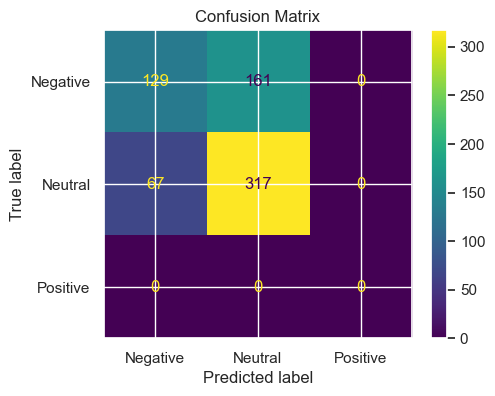

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.55      0.64      0.59       459
     Neutral       0.44      0.28      0.34       459
    Positive       0.58      0.69      0.63       459

    accuracy                           0.54      1377
   macro avg       0.52      0.54      0.52      1377
weighted avg       0.52      0.54      0.52      1377

0.5388525780682644


In [23]:
#TODO : Funktioniert noch nicht
uni_nb = MultinomialNB()
uni_nb.fit(uni_train_bow, train_labels)
 
predictions = uni_nb.predict(uni_test_bow)

acc_nb_uni_bow = test_statistics(predictions, test_labels)
print(acc)
#print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['-1','0','1']))

##### 4.1.1.2 TGIDF

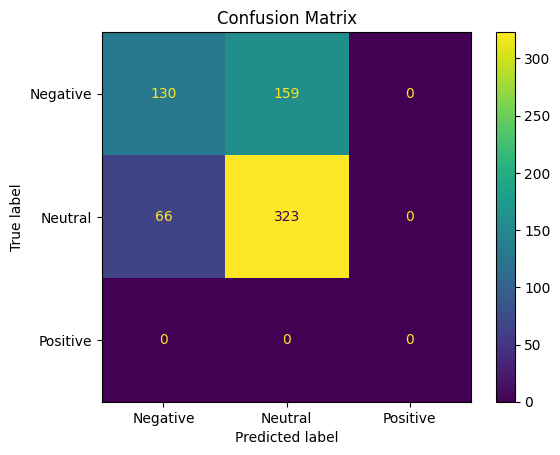

Classifcation Report:
              precision    recall  f1-score   support

    Negative       0.54      0.62      0.58       459
     Neutral       0.43      0.28      0.34       459
    Positive       0.59      0.70      0.64       459

    accuracy                           0.54      1377
   macro avg       0.52      0.54      0.52      1377
weighted avg       0.52      0.54      0.52      1377



In [11]:
uni_nb = MultinomialNB()
uni_nb.fit(uni_train_tgidf, train_labels)
 
predictions = uni_nb.predict(uni_test_tgidf)

acc = test_statistics(predictions, test_labels)

In [13]:
# blaue Confusion Matrix:
"""import seaborn as sns
import matplotlib.pyplot as plt  

co_ma = sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[-1, 0, 1])   

ax= plt.subplot()
sns.heatmap(co_ma, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues);  #annot=True to annotate cells, ftm='g' to disable scientific notation
sns.set (rc = {'figure.figsize':(5, 4)})
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['-1', '0','1']); ax.yaxis.set_ticklabels(['-1', '0','1'])"""

"import seaborn as sns\nimport matplotlib.pyplot as plt  \n\nco_ma = sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[-1, 0, 1])   \n\nax= plt.subplot()\nsns.heatmap(co_ma, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues);  #annot=True to annotate cells, ftm='g' to disable scientific notation\nsns.set (rc = {'figure.figsize':(5, 4)})\n# labels, title and ticks\nax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); \nax.set_title('Confusion Matrix'); \nax.xaxis.set_ticklabels(['-1', '0','1']); ax.yaxis.set_ticklabels(['-1', '0','1'])"

#### 4.1.2 Naive Bayes: Unigram + Bigram

##### 4.1.2.1 Bag-of-Words

In [17]:
bi_nb = MultinomialNB()
bi_nb.fit(bi_train_bow, train_labels)
 
predictions = bi_nb.predict(bi_test_bow)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['-1','0','1']))


              precision    recall  f1-score   support

          -1       0.44      0.38      0.41       459
           0       0.34      0.49      0.40       459
           1       0.57      0.39      0.47       459

    accuracy                           0.42      1377
   macro avg       0.45      0.42      0.43      1377
weighted avg       0.45      0.42      0.43      1377



##### 4.1.2.2 TGIDF

In [ ]:
bi_nb = MultinomialNB()
bi_nb.fit(bi_train_tgidf, train_labels)
 
predictions = bi_nb.predict(bi_test_tgidf)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['-1','0','1']))

#### 4.1.3 Naive Bayes: Unigram + Bigram + Trigram

##### 4.1.3.1 Bag-of-Words

In [19]:
tri_nb = MultinomialNB()
tri_nb.fit(tri_train_bow, train_labels)
 
predictions = tri_nb.predict(tri_test_bow)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['-1','0','1']))


              precision    recall  f1-score   support

          -1       0.44      0.39      0.41       459
           0       0.34      0.48      0.40       459
           1       0.57      0.41      0.47       459

    accuracy                           0.43      1377
   macro avg       0.45      0.43      0.43      1377
weighted avg       0.45      0.43      0.43      1377



##### 4.1.3.2 TGIDF

In [ ]:
tri_nb = MultinomialNB()
tri_nb.fit(tri_train_tgidf, train_labels)
 
predictions = tri_nb.predict(tri_test_tgidf)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['-1','0','1']))

### 4.2 Logistische Regression
#### 4.2.1. Unigram

##### 4.2.1.1 Bag-of-Words

In [21]:
uni_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
uni_logreg.fit(uni_train_bow, train_labels)
#print (uni_logreg)

""" default state of the classifier: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)"""

# Predictions für unseren Test-Datensatz, Accuracy, Confusion-Matrix berechnen: 

predictions = uni_logreg.predict(uni_test_bow)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['-1','0','1']))


              precision    recall  f1-score   support

          -1       0.47      0.32      0.38       459
           0       0.35      0.66      0.46       459
           1       0.61      0.25      0.36       459

    accuracy                           0.41      1377
   macro avg       0.48      0.41      0.40      1377
weighted avg       0.48      0.41      0.40      1377



##### 4.2.1.2 TGIDF

In [ ]:
uni_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
uni_nb.fit(uni_train_tgidf, train_labels)
 
predictions = uni_logreg.predict(uni_test_tgidf)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['-1','0','1']))

#### 4.2.2. Log Regression: Unigrams + Bigrams

##### 4.2.2.1 Bag-of-Words

In [24]:
bi_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
bi_logreg.fit(bi_train_bow, train_labels)

predictions = bi_logreg.predict(bi_test_bow)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['-1','0','1']))
# Feature-Set Größe erhöht sich weil auch Bi-Gramme berücksichtigt 

              precision    recall  f1-score   support

          -1       0.47      0.38      0.42       459
           0       0.37      0.61      0.46       459
           1       0.59      0.31      0.41       459

    accuracy                           0.43      1377
   macro avg       0.47      0.43      0.43      1377
weighted avg       0.47      0.43      0.43      1377

[[175 233  51]
 [129 281  49]
 [ 69 248 142]]


##### 4.2.2.2 TGIDF

In [ ]:
bi_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
bi_logreg.fit(bi_train_tgidf, train_labels)

predictions = bi_logreg.predict(bi_test_tgidf)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['-1','0','1']))

#### 4.2.3. Log Regression: Unigrams + Bigrams + Trigrams

##### 4.2.3.1 Bag-of-Words

In [25]:
tri_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
tri_logreg.fit(tri_train_bow, train_labels)

predictions = tri_logreg.predict(tri_test_bow)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['-1','0','1']))

              precision    recall  f1-score   support

          -1       0.46      0.40      0.43       459
           0       0.36      0.57      0.44       459
           1       0.55      0.31      0.39       459

    accuracy                           0.42      1377
   macro avg       0.46      0.42      0.42      1377
weighted avg       0.46      0.42      0.42      1377



##### 4.2.3.2 TGIDF

In [ ]:
tri_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
tri_logreg.fit(tri_train_tgidf, train_labels)

predictions = tri_logreg.predict(tri_test_tgidf)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['-1','0','1']))

### 4.3 Linear Support Vector Machine (LSVM) 
#### 4.3.1. Unigram 

##### 4.3.1.1 Bag-of-Words

In [27]:
uni_lsvm = sklearn.svm.LinearSVC()
uni_lsvm.fit(uni_train_bow, train_labels)
 
predictions = uni_lsvm.predict(uni_test_bow)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['-1','0','1']))

              precision    recall  f1-score   support

          -1       0.47      0.35      0.40       459
           0       0.36      0.64      0.46       459
           1       0.54      0.27      0.36       459

    accuracy                           0.42      1377
   macro avg       0.46      0.42      0.41      1377
weighted avg       0.46      0.42      0.41      1377



##### 4.3.1.2 TGIDF

In [ ]:
uni_lsvm = sklearn.svm.LinearSVC()
uni_lsvm.fit(uni_train_tgidf, train_labels)
 
predictions = uni_lsvm.predict(uni_test_tgidf)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['-1','0','1']))

#### 4.3.2. LSVM: Unigram + Bigram 

##### 4.3.2.1 Bag-of-Words

In [29]:
bi_lsvm = sklearn.svm.LinearSVC()
bi_lsvm.fit(bi_train_bow, train_labels)
 
predictions = bi_lsvm.predict(bi_test_bow)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['-1','0','1']))

              precision    recall  f1-score   support

          -1       0.44      0.38      0.41       459
           0       0.36      0.58      0.45       459
           1       0.56      0.30      0.39       459

    accuracy                           0.42      1377
   macro avg       0.45      0.42      0.41      1377
weighted avg       0.45      0.42      0.41      1377



##### 4.3.2.2 TGIDF

In [ ]:
bi_lsvm = sklearn.svm.LinearSVC()
bi_lsvm.fit(bi_train_tgidf, train_labels)
 
predictions = bi_lsvm.predict(bi_test_tgidf)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['-1','0','1']))

#### 4.3.3. LSVM: Unigram + Bigram + Trigram

##### 4.3.3.1 Bag-of-Words

In [31]:
tri_lsvm = sklearn.svm.LinearSVC()
tri_lsvm.fit(tri_train_bow, train_labels)
 
predictions = tri_lsvm.predict(tri_test_bow)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['-1','0','1']))

              precision    recall  f1-score   support

          -1       0.46      0.38      0.42       459
           0       0.36      0.62      0.46       459
           1       0.55      0.26      0.35       459

    accuracy                           0.42      1377
   macro avg       0.46      0.42      0.41      1377
weighted avg       0.46      0.42      0.41      1377



##### 4.3.3.2 TGIDF

In [ ]:
tri_lsvm = sklearn.svm.LinearSVC()
tri_lsvm.fit(tri_train_tgidf, train_labels)
 
predictions = tri_lsvm.predict(tri_test_tgidf)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['-1','0','1']))

# Sentiment Analysis Bag-of-Words
## Tweets (Larger Data-Set)

In [35]:
import csv
with open("data/tweets.csv") as csvdatei:
    data = pd.read_csv(csvdatei, delimiter=',')

data.columns = ['Sentiment','ID','date','flag','user','Phrase']
data.drop(['date','flag','user'], axis=1, inplace=True)
data = sklearn.utils.shuffle(data)

data.Sentiment.value_counts()

FileNotFoundError: [Errno 2] No such file or directory: '../data/tweets.csv'

In [ ]:
import nltk
# nltk.download('stopwords')
# pip install nltk
import re

# Zeitbedarf: 7m 14s


# Für Sentimentanalyse zählen nur Wörter  
def keep_only_letters(text):
    text=re.sub(r'[^a-zA-Z\s]','',text)
    return text
 
# Groß- und Kleinschreibung egal 
def convert_to_lowercase(text):
    return text.lower()
 
def clean_reviews(text):
    text = keep_only_letters(text)
    text = convert_to_lowercase(text)
    return text


# Stop Words definition
english_stop_words = nltk.corpus.stopwords.words('english')
#print(len(english_stop_words))
#print (english_stop_words[:20])

# Stop Words removal
def remove_stop_words(text):
    for stopword in english_stop_words:
        stopword = ' ' + stopword + ' '
        text = text.replace(stopword, ' ')
    return text


# Stemming
def text_stemming(text):
    stemmer = nltk.porter.PorterStemmer()
    stemmed = ' '.join([stemmer.stem(token) for token in text.split()])
    return stemmed




#data['Phrase'] = data['Phrase'].apply(clean_reviews)
# test_set['Phrase'] = test_set['Phrase'].apply(clean_reviews)

#data['Phrase'] = data['Phrase'].apply(remove_stop_words)
# test_set['Phrase'] = test_set['Phrase'].apply(remove_stop_words)

#data['Phrase'] = data['Phrase'].apply(text_stemming) 
#test_set['Phrase'] = test_set['Phrase'].apply(text_stemming)

In [ ]:
# Train Test Split
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.2)

In [ ]:
train_set.Sentiment.value_counts()

## 3. Text Vectorization

In [ ]:
import sklearn
# convert text data to numeric

# Argument binary=False: Vocabel-Vector mit term-frequency füllen
# binary = True: Vocabel-Vector mit Vorhandensein der Token füllen (1 vorhanden, 0 nicht vorhanden) 
# ngram _range = Unigram: (1,1); Bigram: (1,2); Trigram: (1,3)

vectorizer_uni_bow = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,1))
vectorizer_bi_bow = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,2))
vectorizer_tri_bow = sklearn.feature_extraction.text.CountVectorizer(binary=False,ngram_range=(1,3))


In [ ]:
# Dauer mit Cleaning: 3m 24s 
# Dauer ohne Cleaning: 4m 46s 

uni_train_bow = vectorizer_uni_bow.fit_transform(train_set['Phrase'])
uni_test_bow = vectorizer_uni_bow.transform(test_set['Phrase'])
#print (uni_features_train.shape, uni_features_test.shape)

bi_train_bow = vectorizer_bi_bow.fit_transform(train_set['Phrase'])
bi_test_bow = vectorizer_bi_bow.transform(test_set['Phrase'])
#print (bi_features_train.shape, bi_features_test.shape)

tri_train_bow = vectorizer_tri_bow.fit_transform(train_set['Phrase'])
tri_test_bow = vectorizer_tri_bow.transform(test_set['Phrase'])
#print (tri_features_train.shape, tri_features_test.shape)

In [ ]:
train_labels = train_set['Sentiment']
test_labels = test_set['Sentiment']

## Klassifizierungsmodelle trainieren

In [ ]:
# Naive Bayes Unigram 
# mit Cleaning: Zeit: 2s Accuracy: 0.77
# ohne Cleaning: Zeit: 2s Accuracy: 0.78

from sklearn.naive_bayes import MultinomialNB

uni_nb = MultinomialNB()
uni_nb.fit(uni_train_bow, train_labels)
 
predictions = uni_nb.predict(uni_test_bow)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['0','1']))

In [ ]:
co_ma = sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 1])   

ax= plt.subplot()
sns.heatmap(co_ma, annot=True, fmt='g', ax=ax, cmap=plt.cm.Blues);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['0','1']); ax.yaxis.set_ticklabels(['0','1'])

In [ ]:
# Naive Bayes Unigram + Bigram
# mit Cleaning: Zeit: 6.5s Accuracy: 0.78
# ohne Cleaning: Zeit: 6.5s Accuracy: 0.80

bi_nb = MultinomialNB()
bi_nb.fit(bi_train_bow, train_labels)
 
predictions = bi_nb.predict(bi_test_bow)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['0','4']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 4]))


In [ ]:
# Naive Bayes Unigram + Bigram + Trigram
# mit Cleaning: Zeit: 4.2s Accuracy: 0.79
# mit Cleaning: Zeit: 4.2s Accuracy: 0.80

tri_nb = MultinomialNB()
tri_nb.fit(tri_train_bow, train_labels)
 
predictions = tri_nb.predict(tri_test_bow)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['0','4']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 4]))


In [ ]:
# Logistische Regression Unigram
# mit Cleaning: Zeit: 5m 50s Accuracy: 0.78
# ohne Cleaning: Zeit: 7m 26s Accuracy: 0.80


uni_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
uni_logreg.fit(uni_train_bow, train_labels)

predictions = uni_logreg.predict(uni_test_bow)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['0','4']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 4]))


In [ ]:
# Logistische Regression Unigram + Bigram
# mit Cleaning: Zeit: 20m 7s Accuracy: 0.80 


bi_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
bi_logreg.fit(bi_train_bow, train_labels)
#print (bi_logreg)

predictions = bi_logreg.predict(bi_test_bow)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['0','4']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 4]))
# Feature-Set Größe erhöht sich weil auch Bi-Gramme berücksichtigt 

In [ ]:
# Logistische Regression Unigram + Bigram + Trigram
# mit Cleaning: Zeit: 36m 21s Accuracy: 0.80 

tri_logreg = sklearn.linear_model.LogisticRegression(max_iter=10000)
tri_logreg.fit(tri_train_bow, train_labels)
#print (tri_logreg)

predictions = tri_logreg.predict(tri_test_bow)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['0','4']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 4]))

In [ ]:
# Linear Support Vector Machine (LSVM) Unigram
# mit Cleaning: Zeit: 10m 12s Accuracy: 0.77 

uni_lsvm = sklearn.svm.LinearSVC(max_iter=10000)
uni_lsvm.fit(uni_train_bow, train_labels)
 
predictions = uni_lsvm.predict(uni_test_bow)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['0','4']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 4]))

In [ ]:
# Linear Support Vector Machine (LSVM) Unigram + Bigram
# mit Cleaning: Zeit: 11m 30s Accuracy: 0.79 

bi_lsvm = sklearn.svm.LinearSVC(max_iter=10000)
bi_lsvm.fit(bi_train_bow, train_labels)
 
predictions = bi_lsvm.predict(bi_test_bow)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['0','4']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 4]))

In [ ]:
# Linear Support Vector Machine (LSVM) Unigram + Bigram + Trigram
# mit Cleaning: Zeit: 13m 10s Accuracy: 0.79

tri_lsvm = sklearn.svm.LinearSVC(max_iter=10000)
tri_lsvm.fit(tri_train_bow, train_labels)
 
predictions = tri_lsvm.predict(tri_test_bow)
print(sklearn.metrics.classification_report(test_labels, predictions, target_names=['0','4']))
print(sklearn.metrics.confusion_matrix(test_labels, predictions, labels=[0, 4]))